In [301]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import time
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
import sklearn.metrics
from sklearn.model_selection import train_test_split
import math
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

In [319]:
x_train = pd.read_csv('x_train_full.csv')
x_val = pd.read_csv('x_val_full.csv')
x_test = pd.read_csv('x_test_full.csv')
y_train = pd.read_csv('./Data with correct player_atts/y_train.csv')
y_val = pd.read_csv('./Data with correct player_atts/y_val.csv')
y_test = pd.read_csv('./Data with correct player_atts/y_test.csv')

x_full = pd.concat([x_train,x_val,x_test], axis = 0)
y_full = pd.concat([y_train,y_val,y_test], axis = 0)

match = pd.read_csv('./Data/Match.csv')

In [320]:
x_full = x_full.merge(match[['match_api_id','league_id']], how = 'left', on ='match_api_id')
y_full = y_full.merge(match[['match_api_id','league_id']], how = 'left', on = 'match_api_id')

assert (x_full.match_api_id == y_full.match_api_id).sum() == len(x_full)

## Data Processing

In [321]:
x_pl = x_full[x_full['league_id']==1729].drop(columns ='league_id')
y_pl = y_full[y_full['league_id']==1729].drop(columns ='league_id')

x_train, x_val, y_train, y_val = train_test_split(x_pl,y_pl, test_size = 0.2, random_state = 42)
x_train.shape

(2187, 35)

In [322]:
x_train.columns

Index(['match_api_id', 'home_player_1_overall_rating',
       'home_player_2_overall_rating', 'home_player_3_overall_rating',
       'home_player_4_overall_rating', 'home_player_5_overall_rating',
       'home_player_6_overall_rating', 'home_player_7_overall_rating',
       'home_player_8_overall_rating', 'home_player_9_overall_rating',
       'home_player_10_overall_rating', 'home_player_11_overall_rating',
       'away_player_1_overall_rating', 'away_player_2_overall_rating',
       'away_player_3_overall_rating', 'away_player_4_overall_rating',
       'away_player_5_overall_rating', 'away_player_6_overall_rating',
       'away_player_7_overall_rating', 'away_player_8_overall_rating',
       'away_player_9_overall_rating', 'away_player_10_overall_rating',
       'away_player_11_overall_rating', 'home_team_form', 'away_team_form',
       'home_team_home_form', 'away_team_away_form', 'home_team_scoring_form',
       'away_team_scoring_form', 'home_team_defensive_form',
       'away_tea

In [326]:
label_dict = {1:0, 0:1, -1:2 }
y_train['target'] = y_train['result'].map(label_dict)
y_val['target'] =  y_val['result'].map(label_dict)
#y_test['target'] =  y_test['result'].map(label_dict)

C:\Users\Jack.Dai\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Jack.Dai\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [156]:
## Rebalance proportion of home wins/draws/home losses
indices = y_train[y_train['result'] == 1].sample(frac = 0.35).index.values
mask_y= ~ y_train.index.isin(indices)
mask_x= ~ x_train.index.isin(indices)
y_train = y_train[mask_y]
x_train = x_train[mask_x]
assert len(x_train) == len(y_train)
assert (x_train.index == y_train.index).sum()
assert (x_train.match_api_id == y_train.match_api_id).sum()

In [327]:
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train.iloc[:,1:])

x_train = pd.DataFrame(min_max_scaler.transform(x_train.iloc[:,1:]), index = x_train['match_api_id'], columns = x_train.iloc[:,1:].columns)
x_val = pd.DataFrame(min_max_scaler.transform(x_val.iloc[:,1:]), index = x_val['match_api_id'], columns = x_val.iloc[:,1:].columns)
#x_test = pd.DataFrame(min_max_scaler.transform(x_test.iloc[:,1:]), index = x_test['match_api_id'], columns = x_test.iloc[:,1:].columns)

In [328]:
y_train['result'].value_counts(normalize=True)

 1    0.443073
-1    0.290352
 0    0.266575
Name: result, dtype: float64

In [361]:
# Build Network
input_size = len(x_train.columns)
hidden_sizes = [256,512,512,128,32,16]
output_size = 3

# Build a feed-forward network
LinearNN = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                        nn.ReLU(),
                        nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                        nn.ReLU(),
                        nn.Linear(hidden_sizes[3], hidden_sizes[4]),
                        nn.ReLU(),
                        nn.Linear(hidden_sizes[4], hidden_sizes[5]),
                        nn.ReLU(),
                         nn.Linear(hidden_sizes[5], output_size),
                      nn.Softmax()
                        )



ValueError: dropout probability has to be between 0 and 1, but got 34

In [483]:
# Build Network
input_size = len(x_train.columns)
hidden_sizes = [256,512,512,128,32,16]
output_size = 3
prob = 0.5
# Build a feed-forward network
LinearNN = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                          nn.Dropout(p=prob),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                          nn.Dropout(p=prob),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                        nn.ReLU(),
                          nn.Dropout(p=prob),
                        nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                        nn.ReLU(),
                          nn.Dropout(p=prob),
                        nn.Linear(hidden_sizes[3], hidden_sizes[4]),
                        nn.ReLU(),
                         nn.Dropout(p=prob),
                        nn.Linear(hidden_sizes[4], hidden_sizes[5]),
                        nn.ReLU(),
                         nn.Dropout(p=prob),
                         nn.Linear(hidden_sizes[5], output_size),
                      nn.Softmax()
                        )



In [484]:
# Hyperparameters

batch_size = 512 #len(x_train)
epochs = 1000
learning_rate = 0.0001
loss = 0
losses = []
losses_val = []
counter = 0


dataset = TensorDataset( Tensor(x_train.values), torch.Tensor(y_train['target'].values) )
train_loader = DataLoader(dataset, batch_size = batch_size, shuffle=False)

optimizer = torch.optim.Adam(LinearNN.parameters(), lr=learning_rate, betas=(0.9,0.999))

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 200 , gamma = 0.1)
mse = torch.nn.MSELoss()
cross = nn.CrossEntropyLoss()

Loss after iteration 0: 1.0945545434951782
Loss after iteration 500: 1.0865986347198486
Loss after iteration 1000: 1.0193874835968018
Loss after iteration 1500: 1.037899374961853
Loss after iteration 2000: 1.0184650421142578
Loss after iteration 2500: 1.007802963256836
Loss after iteration 3000: 1.001377820968628
Loss after iteration 3500: 0.9994593858718872
Loss after iteration 4000: 0.9314587116241455
Loss after iteration 4500: 0.9920032024383545
Loss after iteration 5000: 0.9809586405754089
Loss after iteration 5500: 0.8968643546104431
Elapsed time: 358.67098927497864 s
0.8810177445411682


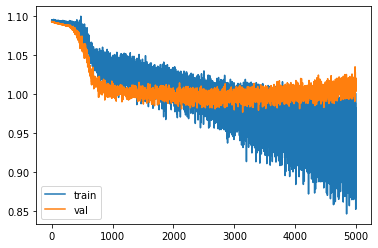

In [485]:
#Train Model

t = time.time()
for epoch in range(epochs):
    for x, y in iter(train_loader):
        LinearNN.train()
        LinearNN.zero_grad()
        
        y_pred = LinearNN(x)
        y_val_pred = LinearNN(Tensor(x_val.values))

        loss = cross(y_pred, y.long())
        loss_val = cross(y_val_pred, Tensor(y_val['target'].values).long())

        if counter % 500 ==0:
            print('Loss after iteration {}: {}'.format(counter, loss.item()))
        
        losses.append(loss.item())
        losses_val.append(loss_val.item())
        
        loss.backward()
        optimizer.step()
        
        counter+=1 
    counter+=1
    #scheduler.step()
time.time()-t        
        
        
print('Elapsed time: {} s'.format(time.time()-t))    
print(loss.item())  
plt.plot(range(len(losses)), losses, label = 'train')
plt.plot(range(len(losses)), losses_val, label = 'val')
plt.legend(loc="lower left")
plt.show()

In [487]:
##Eval 

LinearNN.eval()
with torch.no_grad():
    val_pred = LinearNN(Tensor(x_val.values))
    train_pred = LinearNN(Tensor(x_train.values))
y_val_pred = pd.Series(val_pred.max(1).indices).map({0:1,1:0,2:-1})
y_train_pred = pd.Series(train_pred.max(1).indices).map({0:1,1:0,2:-1})

print(sklearn.metrics.accuracy_score(y_train_pred, y_train['result']))
print(sklearn.metrics.accuracy_score(y_val_pred, y_val['result']))

0.6095107453132145
0.4716636197440585


In [488]:
y_val_pred.value_counts()

 1    279
 0    156
-1    112
dtype: int64

In [280]:
##Test 

LinearNN.eval()
with torch.no_grad():
    val_pred = LinearNN(Tensor(x_test.values))
    
y_val_pred = pd.Series(val_pred.max(1).indices).map({0:1,1:0,2:-1})
sklearn.metrics.accuracy_score(y_val_pred, y_test['result'])

0.5425434583714547

In [275]:
y_val_pred.value_counts()

 1    797
-1    296
dtype: int64

In [200]:
val_pred[y_val['result'] == 0]

IndexError: The shape of the mask [1094] at index 0does not match the shape of the indexed tensor [1093, 3] at index 0

In [253]:
y_pred[:,1].max()

tensor(0.2545, grad_fn=<MaxBackward1>)